# Simple $1$-form Convolutional Network

In this notebook, we develop a few examples of simple De Rham Neural Networks.

In [5]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

# Generate some graph data to play around with

In [106]:
import networkx as nx
import torch_geometric

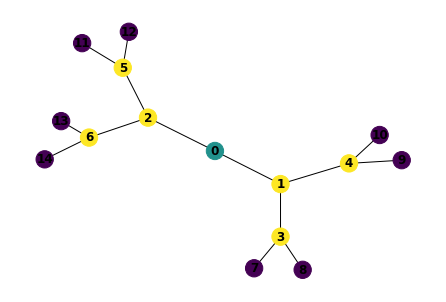

In [143]:
# draw a tree graph with 10 nodes
G = nx.balanced_tree(2, 3)


# identify the leaves in the graph
leaves = [node for node in G.nodes() if G.degree(node) == 1]

# color the leaves red
node_colors = ['r' if node in leaves else 'b' for node in G.nodes()]

# plot the graph with the colored leaves
nx.draw(G, with_labels=True, font_weight='bold', node_color=list(dict(G.degree()).values()))

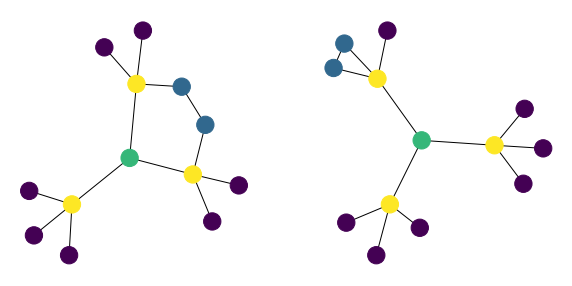

In [144]:
# draw a tree graph with 10 nodes
G = nx.balanced_tree(3, 2)

# add an edge between 4 and 11
G.add_edge(6, 11)

# draw a tree graph with 10 nodes
H = nx.balanced_tree(3, 2)

# add an edge between 7 and 8
H.add_edge(7, 8)

# calculate the spring layout for H
Gpos = nx.spring_layout(G)
Hpos = nx.spring_layout(H)

# draw the graphs on two subfigures, side by side, colored by their respective node degrees
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
nx.draw(G, pos=Gpos, with_labels=False, font_weight='bold', node_color=list(dict(G.degree()).values()))
plt.subplot(1, 2, 2)
nx.draw(H, pos=Hpos, with_labels=False, font_weight='bold', node_color=list(dict(H.degree()).values()))

## Turning graphs into tensors

In [167]:
# a function for turning a path into a chain
def nxgraph_to_chain(graph, features):
    """ 
    A function for turning a graph into a chain
    Inputs: 
        graph: an nx_graph
        features: a torch tensor of features for each node of size (m,n) where m is the number of nodes and n is the feature dimension

    outputs:
        ch: a torch tensor of shape (r,2,n) where r is the number of edges and n is the feature dimension
    """

    # get node features
    node_features = features

    # get edges
    edge_index = torch.tensor(list(graph.edges))

    # number of 1-simplices
    r = edge_index.shape[0]

    # embedding dimension
    n = node_features.shape[1]

    # sort the edge indices
    edges = torch.tensor([np.sort([edge_index[i][0],edge_index[i][1]]) for i in range(len(edge_index))])

    # initialize chain
    ch = torch.zeros((r,2,n))

    # turn edges into a 1-chain
    for i in range(r):
        ch[i,0,:] = node_features[edges[i][0]]
        ch[i,1,:] = node_features[edges[i][1]]

    return ch

In [169]:
nxgraph_to_chain(G, Gpos).shape

torch.Size([13, 2, 2])

In [172]:
# extract the degree sequence from the graph
degree_sequence = list(dict(G.degree()).values())

degree_sequence = torch.tensor(degree_sequence).float()

# one hot encode the degree sequence
one_hot_degree_sequence = torch.nn.functional.one_hot(degree_sequence.to(torch.int64))

one_hot_degree_sequence

tensor([[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0]])

In [175]:
# extract the degree sequence from the graph
degree_sequence = list(dict(H.degree()).values())

degree_sequence = torch.tensor(degree_sequence).float()

# one hot encode the degree sequence
Hone_hot_degree_sequence = torch.nn.functional.one_hot(degree_sequence.to(torch.int64))

Hone_hot_degree_sequence

tensor([[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0]])

By convention, we will always use $Z$ to denote matrix the positional, equivariant node features, and $H$ to denote the matrix of 'scalar' or non-equivariant node features. If the position of the nodes is in $\mathbb{R}^n$ and the scalar features are in $\mathbb{R}^m$, the respective matrices are in $\mathbb{R}^{s_0 \times n}$ and $\mathbb{R}^{s_0 \times m}$, where $s_0$ is the number of nodes in the graph.

In [199]:
# make a dictionary containing: the graph G, the node positions Gpos, and the one hot degree sequence, the chains
Gdata = {'graph': G, 'Z': Gpos.float(), 'H': one_hot_degree_sequence.float(), 'Z_chains': nxgraph_to_chain(G, Gpos), 'H_chains' : nxgraph_to_chain(G, one_hot_degree_sequence).float()}

# make a dictionary containing: the graph H, the node positions Hpos, and the one hot degree sequence, the chains
Hdata = {'graph': H, 'Z': Hpos.float(), 'H': Hone_hot_degree_sequence.float(), 'Z_chains': nxgraph_to_chain(H, Hpos), 'H_chains' : nxgraph_to_chain(H, Hone_hot_degree_sequence).float()}


We will also use the coboundary of the positional and scalar features. These matrices are $dZ \in \mathbb{R}^{s_1 \times n}$ and $dH \in \mathbb{R}^{s_1 \times m}$, where $s_1$ is the number of edges in the graph. These encode the tangent vector along each edge wrt these respective coordinate types.

In [200]:
Gdata['dZ'] = (Gdata['Z_chains'][:,1,:] - Gdata['Z_chains'][:,0,:])
Gdata['dH'] = (Gdata['H_chains'][:,1,:] - Gdata['H_chains'][:,0,:])
Hdata['dZ'] = (Hdata['Z_chains'][:,1,:] - Hdata['Z_chains'][:,0,:])
Hdata['dH'] = (Hdata['H_chains'][:,1,:] - Hdata['H_chains'][:,0,:])

In [201]:
Gdata['Z'].T.float() @ Gdata['H'].float()

tensor([[ 0.0000, -1.0301,  1.0961, -0.0453, -0.0206],
        [ 0.0000, -0.7322,  0.7790, -0.0339, -0.0128]])

(-1.0, 1.0)

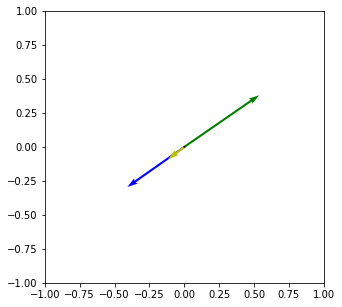

In [211]:
vec = Gdata['dZ'].T @ Gdata['dH']

# plot the columns of vec as vectors starting from the origin
plt.figure(figsize=(5,5))

# plot the columns of vec as vectors starting from the origin

plt.quiver(0, 0, vec[0,0], vec[1,0], angles='xy', scale_units='xy', scale=1, color='r')

plt.quiver(0, 0, vec[0,1], vec[1,1], angles='xy', scale_units='xy', scale=1, color='b')

plt.quiver(0, 0, vec[0,2], vec[1,2], angles='xy', scale_units='xy', scale=1, color='g')

plt.quiver(0, 0, vec[0,3], vec[1,3], angles='xy', scale_units='xy', scale=1, color='y')

plt.quiver(0, 0, vec[0,4], vec[1,4], angles='xy', scale_units='xy', scale=1, color='k')

# zoom out
plt.xlim(-1, 1)

plt.ylim(-1, 1)

# plot the columns of vec as vectors starting from the origin

(-1.0, 1.0)

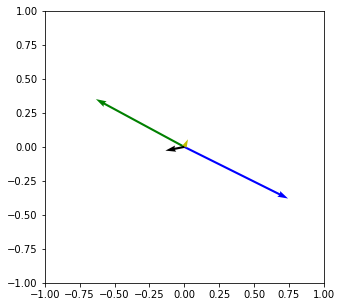

In [207]:
vec = Hdata['dZ'].T @ Hdata['dH']

# plot the columns of vec as vectors starting from the origin
plt.figure(figsize=(5,5))

# plot the columns of vec as vectors starting from the origin

plt.quiver(0, 0, vec[0,0], vec[1,0], angles='xy', scale_units='xy', scale=1, color='r')

plt.quiver(0, 0, vec[0,1], vec[1,1], angles='xy', scale_units='xy', scale=1, color='b')

plt.quiver(0, 0, vec[0,2], vec[1,2], angles='xy', scale_units='xy', scale=1, color='g')

plt.quiver(0, 0, vec[0,3], vec[1,3], angles='xy', scale_units='xy', scale=1, color='y')

plt.quiver(0, 0, vec[0,4], vec[1,4], angles='xy', scale_units='xy', scale=1, color='k')

# zoom out
plt.xlim(-1, 1)

plt.ylim(-1, 1)

# plot the columns of vec as vectors starting from the origin

In [230]:
Gdata['Z'].shape

Gdata['Z'].T @ Gdata['H']

base = torch.cat((Gdata['Z'].T @ Gdata['H'], Gdata['dZ'].T @ Gdata['dH']),axis=1)

base.shape

torch.Size([2, 10])

In [232]:
# build a random tensor of 7x2 
X = torch.rand(7,2)

# shape is batch x (2*non-eq dim)
(X @ base).shape

torch.Size([7, 10])

In [314]:
dimH = 5
dimZ = 2

num_vf = 3

# generate a torch sequential neural network with two hidden layers
model = nn.Sequential(nn.Linear(2*dimH, 32), 
                      nn.ReLU(), 
                      nn.Linear(32, 32), 
                      nn.ReLU(), 
                      nn.Linear(32, (1+2*dimH)*num_vf)
                      )

In [293]:
model(X @ base).shape

out = model(X @ base)

In [294]:
out.shape

torch.Size([7, 33])

In [285]:
print(X.shape)
print(base.shape)

# for each row of X, concatenate the transpose of the rwo iwth the base
c = torch.cat((X.T, base), axis=1)


Y = X.unsqueeze(-1)

print(Y.shape)


# stack the bases along the batch dimension
bases = torch.stack([base] * X.shape[0])

print(bases.shape)

# create a list with X.shape[0] copies of base without using a for loop

full_bases = torch.cat((Y,bases),axis=-1)

full_bases.shape

torch.Size([7, 2])
torch.Size([2, 10])
torch.Size([7, 2, 1])
torch.Size([7, 2, 10])


torch.Size([7, 2, 11])

In [309]:
out = out.view(-1, num_vf, 1+2*dimH)

# switch 1st and 2nd dimensions
out = out.permute(0,2,1)

out.shape

torch.Size([7, 11, 3])

In [290]:
full_bases.shape

torch.Size([7, 2, 11])

In [321]:
# this is the output containing the vector field values of each batch
final = torch.matmul(full_bases, out)

print("final.shape: " , final.shape)

# we wrap it up into the correct format for integration matrix layer
finalwrap = final.view(-1, dimZ * num_vf)

finalwrap.shape

final.shape:  torch.Size([7, 2, 3])


torch.Size([7, 6])

In [219]:

# generate a torch sequential neural network with two hidden layers
model = nn.Sequential(nn.Linear(10, 32), 
                      nn.ReLU(), 
                      nn.Linear(32, 32), 
                      nn.ReLU(), 
                      nn.Linear(32, 1+Gdata['H'].shape[1] + Gdata['dH'].shape[1])
                      )


class equivariant(torch.nn.Module):
    # initialize the class
    def __init__(self, model):
        super(equivariant, self).__init__()
        self.model = model

    # define the forward pass
    def forward(self, data, x):
        """ x is a bxn batch of b vectors in Rn """

        Z = data['Z']
        H = data['H']
        dZ = data['dZ']
        dH = data['dH']

        print(Z.shape)

        inp = x.T @ Z.T @ H # should be dimension b x H.shape[1] where 



        out = self.model(inp)

        # concatenate 
        base = torch.cat((x.T, Z.T @ H, dZ.T @ H ), axis=1)

        base = base @ out.T

        return base
        

In [223]:
# random 5x2 matrix 
x = torch.randn(5,2)

m = equivariant(model)

In [224]:
m(Gdata, x)

torch.Size([13, 2])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x5 and 2x13)

In [5]:
# generate the data
def generate_data(n_samples = 300):

    dataset = []
    graphs = []
    positions = []
    labels = []



    for i in range(n_samples):
        

        if i % 3 == 0:
            # make a networkx graph consisting of a single cycle
            l = np.random.randint(10,20)
            G = nx.cycle_graph(l)

            labels.append(torch.tensor([1,0,0]))

        # make a networkx graph consisting of a single cycle
        if i % 3 == 1:
            l = np.random.randint(10,20)
            G = nx.star_graph(l)

            labels.append(torch.tensor([0,1,0]))

        # make a networkx graph consisting of a tree
        if i % 3 == 2:
            l = np.random.randint(10,20)
            G = nx.random_tree(l)

            labels.append(torch.tensor([0,0,1]))


        # choose a random integer between 1 and 10
        n = np.random.randint(7,10)

        # calculate the spring layout
        pos = nx.spring_layout(G)

        #
        graphs.append(G)
        positions.append(pos)

        # convert graph to a torch geometric data object
        data = torch_geometric.utils.from_networkx(G)
        data['x'] = torch.tensor(list(pos.values())).float()
        data['y'] = labels[-1]

        dataset.append(data)

    return dataset, graphs, positions, labels


# generate the data
dataset, global_graphs, global_positions, labels = generate_data3(n_samples = 200)

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_11319/720891803.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  data['x'] = torch.tensor(list(pos.values())).float()


## Integrating Paths Agains Vector Fields


We first need a few functions for doing efficient path integration in this setting.

In [18]:
# a function for turning a path into a chain
def graph_to_chain(graph):
    """ 
    A function for turning a graph into a chain
    """

    # get node features
    node_features = torch.tensor(graph['x'])

    # get edges
    edge_index =torch.tensor(data['edge_index']).T

    # number of 1-simplices
    r = edge_index.shape[0]

    # embedding dimension
    n = node_features.shape[1]

    # sort the edge indices
    edges = torch.tensor([np.sort([edge_index[i][0],edge_index[i][1]]) for i in range(len(edge_index))])

    # initialize chain
    ch = torch.zeros((r,2,n))

    # turn edges into a 1-chain
    for i in range(r):
        ch[i,0,:] = node_features[edges[i][0]]
        ch[i,1,:] = node_features[edges[i][1]]

    return ch

def path_to_chain(p):
    """  
    A function for turning a path into a chain

    Parameters
    ----------
    p : numpy array
        A path in R^n, represented as a numpy array of shape (p,n), where p is the number of points in the path

    Returns
    -------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.
        The middle index corresponds to start and endpoints of the edges in the chain.
    """

    r = len(p) - 1

    n = p[0].shape[0]
    
    
    chain = torch.zeros((r,2,n))

    chain[:,1,:] = torch.tensor(p[1:,:])
    chain[:,0,:] = torch.tensor(p[0:-1,:])

    return chain

    
# a function for turning a chain into a discretized chain
def discretize_chain(chain,d):
    """ 
    A function for turning a chain into a discretized chain

    Parameters
    ----------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.

    d : int
        The number of points in the discretized chain

    Returns
    -------
    d_chain : numpy array
        A discretized chain in R^n, represented as a numpy array of shape (p-1,d,n), where p is the number of points in the path.

    """

    r = chain.shape[0]

    n = chain.shape[2]

    d_chain = torch.zeros((r,d,n))

    t = np.linspace(0,1,d)

    for i in range(d):

        d_chain[:,i,:] = (1-t[i]) * chain[:,0,:] + t[i] * chain[:,1,:] 

    return d_chain



In [15]:
# a function for turning a chain into a cochain data matrix
def gen_CDM2(vf,chain, d = 5):
    """
    A function for generating a cochain data matrix from a chain and a vector field

    Parameters
    ----------
    vf : a Pytorch Sequential object
        The vector field to be applied to the chain
    
    chain : a torch tensor of shape (r,2,n)
        The chain to be turned into a cochain data matrix

    d : int
        The number of discrete steps in the discretization of the chain
    
    Returns
    -------
    out : a torch tensor of shape (r,c)
        The cochain data matrix
    """

    
    # discretize the chain
    chain = discretize_chain(chain, d)

    # number of simplicies
    r = chain.shape[0]

    # number of discrete steps
    d = chain.shape[1]

    # dimension of ambient space
    n = chain.shape[2]

    # number of feature-cochains in the cochain data matrix
    c = int(vf[-1].out_features / n)

    # apply the vector field to the discretized chain
    out = vf(chain).reshape((r,d,n,c))

    # calculate the simplex gradients
    simplex_grad = chain[:,1,:] - chain[:,0,:]

    # swap dimensions n and c in out
    out = out.permute(0,1,3,2)

    # calculate the inner product of the vector field and the simplex gradients at each discrete step on each simplex
    inner_prod = torch.matmul(out,simplex_grad.T/(d-1))

    # take diagonal of out3 along axis 0 and 3 (this corresponds to correcting the broadcasted multplication effect)
    inner_prod = torch.diagonal(inner_prod, dim1 = 0, dim2 = 3)

    # permute dimensions 0 and 2 of out4
    inner_prod = inner_prod.permute(2,0,1)

    # apply the trapzoidal rule to the inner product
    cdm = (inner_prod[:,1:,:] + inner_prod[:,0:-1,:])/2
    cdm = cdm.sum(axis = 1)

    return cdm

In [100]:
# convert the data
# example
chains = []
for data in dataset:
    chains.append(graph_to_chain(data))

NameError: name 'dataset' is not defined

In [8]:
# translate a chain by adding a vector in the dim 2
def translate_chain(chain, v):
    """
    A function for translating a chain by adding a vector in the dim 2

    Parameters
    ----------
    chain : a torch tensor of shape (r,2,n)
        The chain to be translated

    v : a torch tensor of shape (n)
        The vector to translate the chain by
    
    Returns
    -------
    out : a torch tensor of shape (r,2,n)
        The translated chain
    """

    out = chain + v

    return out

# create a grid of 2d vectors in the range [-1,1]x[-1,1]
def create_grid(n):
    """
    A function for creating a grid of 2d vectors in the range [-1,1]x[-1,1]

    Parameters
    ----------
    n : int
        The number of points in the grid
    
    Returns
    -------
    out : a torch tensor of shape (n^2,2)
        The grid of 2d vectors
    """

    x = np.linspace(-1,1,n)
    y = np.linspace(-1,1,n)

    X,Y = np.meshgrid(x,y)

    out = torch.zeros((n**2,2))

    for i in range(n):
        for j in range(n):
            out[i*n + j,0] = X[i,j]
            out[i*n + j,1] = Y[i,j]

    return out


out = create_grid(10)

out.shape

torch.Size([100, 2])

### Synthetic Dataset of paths

# Chain Operations

The philosophy is one should leave the k-form along as much as possible and focus on operations that move the chains around.

In [12]:
chain = chains[0]

IndexError: list index out of range

NameError: name 'chain' is not defined

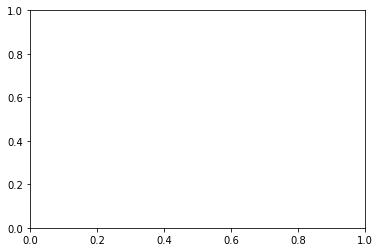

In [13]:
# plot a chain

# initialise plot
fig, ax = plt.subplots()


# for each row in chain, plot the line segment connecting chain[i,0,:] to chain[i,1,:]
for i in range(chain.shape[0]):
    plt.plot(chain[i,:,0],chain[i,:,1], color='b')

plt.show()

In [28]:
def plot_chain(chain, ax):

    # for each row in chain, plot the line segment connecting chain[i,0,:] to chain[i,1,:]
    for i in range(chain.shape[0]):
        ax.plot(chain[i,:,0],chain[i,:,1], color='g')


In [29]:
# restrict the chain to nodes with L1 norm less than 1

def restrict_chain(chain, radius):

    """
    A function for restricting a chain to nodes with L1 norm less than 1

    Parameters
    ----------
    chain : a torch tensor of shape (r,2,n)
        The chain to be restricted

    radius : float
        The radius
    
    Returns
    -------
    out : a subset of chain with rows corresponding to nodes with L1 norm less than 1
    """

    # calculate the L1 norm of each node
    norms = torch.sum(torch.abs(chain), axis = 2)

    radius = radius * chain.shape[2]


    # identify rows where norms[:,0] and norms[:,1] are less than radius
    indices = np.where((norms[:,0] < radius) & (norms[:,1] < radius))



    # return the subset of chain with rows corresponding to nodes with L1 norm less than 1
    out = chain[indices]
    

    return out

In [31]:
def simple_vf_plot(vf, ax, radius = 1):
    x = np.linspace(-radius,radius,10)
    y = np.linspace(-radius,radius,10)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((10,10))
    V = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor(inp).float()

            tv = vf.forward(inp)

            U[i,j] = tv[0]
            V[i,j] = tv[1]
    ax.quiver(X,Y,U,V)


In [38]:
# add 'h' to each elem in dataset consisting of a vector of ones of length x.shape[0]
def add_h(dataset):
    """
    A function for adding 'h' to each elem in dataset consisting of a vector of ones of length x.shape[0]

    Parameters
    ----------
    dataset : a list of torch geometric data objects
        The dataset to be modified
    
    Returns
    -------
    out : a list of torch geometric data objects
        The modified dataset
    """

    out = []

    for data in dataset:
        data['h'] = torch.ones(data['x'].shape[0])
        data['h'] = data['h'].reshape((data['h'].shape[0],1))
        out.append(data)

    return out

dataset = add_h(dataset)

In [44]:
def add_sym(dataset):

    """
    A function for adding 'sym' to each elem in dataset consisting of a vector of ones of length x.shape[0]

    Parameters
    ----------
    dataset : a list of torch geometric data objects
        The dataset to be modified
    
    Returns
    -------
    out : a list of torch geometric data objects
        The modified dataset
    """

    out = []

    for data in dataset:
        data['sym'] = data['h'].T @ data['x'] @ data['x'].T @ data['h']
        data['sym'] = data['sym'].reshape((data['sym'].shape[0],1))
        out.append(data)

    return out

In [45]:
dataset = add_sym(dataset)

In [48]:
graph = dataset[0]

graph['sym'].flatten()

tensor(2.1316e-14)

In [43]:
graph['h'].T @ graph['x'] @ graph['x'].T @ graph['h']

tensor([[2.1316e-14]])

In [21]:
trans = create_grid(20)

In [67]:
## intialise a neural 1-form/vector field in R^2
c = 1 # non-equivariant feature dim
d = 2 # ambient dim
m = 1 # 1-form feat dim

equivec = nn.Sequential(
    nn.Linear(c*c+d, 32),
    nn.LeakyReLU(),
    nn.Linear(32, 32),
    nn.LeakyReLU(),
    nn.Linear(32, m)
)

In [69]:
def equi_vf_plot(vf, graph, ax, radius = 1):
    x = np.linspace(-radius,radius,10)
    y = np.linspace(-radius,radius,10)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((10,10))
    V = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor(inp).float()

            sym = graph['sym'].flatten()

            inp = torch.cat((sym,inp),0)
            tv = vf.forward(inp)

            tv = graph['x'].T @ graph['h'] @ tv

            print(tv)


            U[i,j] = tv[0]
            V[i,j] = tv[1]
    ax.quiver(X,Y,U,V)


In [70]:
# return a rotation matrix in R^2 based on an angle
def rot_mat(theta):
    """
    A function for returning a rotation matrix in R^2 based on an angle

    Parameters
    ----------
    theta : float
        The angle of rotation
    
    Returns
    -------
    out : a torch tensor of shape (2,2)
        The rotation matrix
    """

    out = torch.tensor([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

    # turn out so everything is a float
    out = out.float()
    

    return out

graph2 = graph.clone()

graph2['x'] = graph2['x'] @ rot_mat(np.pi/4)

graph2['sym'] = graph2['h'].T @ graph2['x'] @ graph2['x'].T @ graph2['h']



In [73]:
graph['x']

tensor([[-0.2825,  0.1352],
        [-0.4072,  0.4841],
        [-0.5845,  0.7524],
        [-0.8121,  0.8912],
        [-0.9960,  0.7797],
        [-0.9046,  0.5556],
        [-0.6498,  0.3951],
        [-0.3075,  0.3098],
        [ 0.0623,  0.2598],
        [ 0.4042,  0.1701],
        [ 0.7010,  0.0183],
        [ 0.9160, -0.2059],
        [ 1.0000, -0.4819],
        [ 0.9121, -0.7479],
        [ 0.6837, -0.9047],
        [ 0.3977, -0.9081],
        [ 0.1348, -0.7682],
        [-0.0667, -0.5219],
        [-0.2010, -0.2127]])

In [75]:
graph['x'].T @ graph['h']

tensor([[2.6822e-07],
        [2.3842e-07]])

tensor([-2.1255e-08, -1.8893e-08], grad_fn=<MvBackward0>)
tensor([-2.0609e-08, -1.8319e-08], grad_fn=<MvBackward0>)
tensor([-2.0068e-08, -1.7839e-08], grad_fn=<MvBackward0>)
tensor([-1.9477e-08, -1.7313e-08], grad_fn=<MvBackward0>)
tensor([-1.8723e-08, -1.6643e-08], grad_fn=<MvBackward0>)
tensor([-1.7341e-08, -1.5414e-08], grad_fn=<MvBackward0>)
tensor([-1.6124e-08, -1.4332e-08], grad_fn=<MvBackward0>)
tensor([-1.4907e-08, -1.3250e-08], grad_fn=<MvBackward0>)
tensor([-1.3736e-08, -1.2210e-08], grad_fn=<MvBackward0>)
tensor([-1.2894e-08, -1.1462e-08], grad_fn=<MvBackward0>)
tensor([-2.1038e-08, -1.8701e-08], grad_fn=<MvBackward0>)
tensor([-2.0494e-08, -1.8217e-08], grad_fn=<MvBackward0>)
tensor([-2.0088e-08, -1.7856e-08], grad_fn=<MvBackward0>)
tensor([-1.9454e-08, -1.7293e-08], grad_fn=<MvBackward0>)
tensor([-1.8783e-08, -1.6696e-08], grad_fn=<MvBackward0>)
tensor([-1.7714e-08, -1.5746e-08], grad_fn=<MvBackward0>)
tensor([-1.6299e-08, -1.4488e-08], grad_fn=<MvBackward0>)
tensor([-1.501

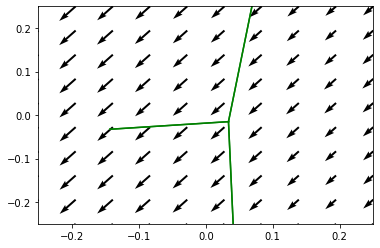

In [78]:
fig, ax = plt.subplots()

radius = 0.25

equi_vf_plot(equivec, graph, ax, radius = radius)

plot_chain(chain, ax)

# make axis limits from -radius to radius
plt.xlim(-radius,radius)
plt.ylim(-radius,radius)

plt.show()

tensor([-2.3617e-09,  6.4946e-08], grad_fn=<MvBackward0>)
tensor([-2.2898e-09,  6.2971e-08], grad_fn=<MvBackward0>)
tensor([-2.2298e-09,  6.1320e-08], grad_fn=<MvBackward0>)
tensor([-2.1641e-09,  5.9512e-08], grad_fn=<MvBackward0>)
tensor([-2.0803e-09,  5.7209e-08], grad_fn=<MvBackward0>)
tensor([-1.9267e-09,  5.2986e-08], grad_fn=<MvBackward0>)
tensor([-1.7915e-09,  4.9267e-08], grad_fn=<MvBackward0>)
tensor([-1.6563e-09,  4.5548e-08], grad_fn=<MvBackward0>)
tensor([-1.5262e-09,  4.1972e-08], grad_fn=<MvBackward0>)
tensor([-1.4327e-09,  3.9399e-08], grad_fn=<MvBackward0>)
tensor([-2.3376e-09,  6.4284e-08], grad_fn=<MvBackward0>)
tensor([-2.2771e-09,  6.2620e-08], grad_fn=<MvBackward0>)
tensor([-2.2320e-09,  6.1379e-08], grad_fn=<MvBackward0>)
tensor([-2.1616e-09,  5.9443e-08], grad_fn=<MvBackward0>)
tensor([-2.0870e-09,  5.7393e-08], grad_fn=<MvBackward0>)
tensor([-1.9683e-09,  5.4127e-08], grad_fn=<MvBackward0>)
tensor([-1.8110e-09,  4.9802e-08], grad_fn=<MvBackward0>)
tensor([-1.667

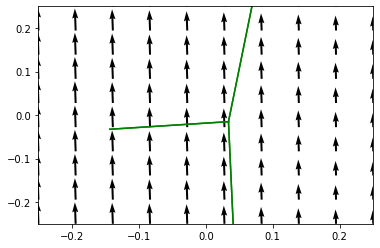

In [72]:
fig, ax = plt.subplots()

radius = 0.25

equi_vf_plot(equivec, graph2, ax, radius = radius)

plot_chain(chain, ax)

# make axis limits from -radius to radius
plt.xlim(-radius,radius)
plt.ylim(-radius,radius)

plt.show()

In [77]:
def transpose(chain, trans, radius):

    multis = []
    transposed_chains = []

    for i in range(len(trans)):

        c = chain - trans[i]
        c = restrict_chain(c, radius)

        transposed_chains.append(c)

        if c.shape[0] > 0:

            multi = torch.zeros((len(trans),c.shape[0]))

            multi[i,:] = torch.ones(c.shape[0])

            multis.append(multi)
            
    multis = torch.cat(multis, axis = 1)

    transposed_chains = torch.cat(transposed_chains, axis = 0)

    return multis, transposed_chains


In [25]:
# stack a chain with all of its translations
translations = create_grid(20)

radius = 0.15

multis = []
transposed_chains = []

for i in range(len(trans)):

    c = chain - trans[i]
    c = restrict_chain(c, radius)

    transposed_chains.append(c)

    if c.shape[0] > 0:

        multi = torch.zeros((len(trans),c.shape[0]))

        multi[i,:] = torch.ones(c.shape[0])

        multis.append(multi)

In [26]:
transpose(chain,radius = 0.15, trans = trans)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[[ 0.0163,  0.2536],
          [ 0.0679,  0.1098]],
 
         [[ 0.0163,  0.2536],
          [-0.0408,  0.1257]],
 
         [[ 0.0163,  0.2536],
          [ 0.0679,  0.1098]],
 
         ...,
 
         [[-0.0341, -0.2336],
          [-0.0028, -0.0767]],
 
         [[-0.0341, -0.2336],
          [-0.1009, -0.0979]],
 
         [[-0.0341, -0.2336],
          [ 0.0795, -0.1323]]]))

In [27]:
# concatenate transposed chains along dimension 0

full_chains = torch.cat(transposed_chains, dim = 0)

In [28]:
full_multis = torch.cat(multis, dim = 1)

In [29]:
Z = gen_CDM2(vf, full_chains)

In [30]:
integrals = full_multis @ torch.abs(Z)

In [31]:
integrals.shape

torch.Size([400, 1])

In [32]:
3 # turn integrals into numpy array
integrals = integrals.detach().numpy()

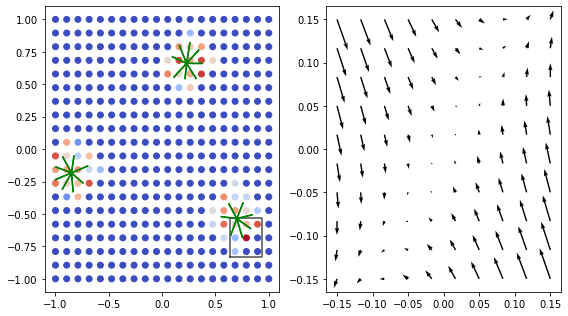

In [33]:
fig, ax = plt.subplots(1,2)

# calculate argmax of integrals
index = np.argmax(integrals)

best = np.array(trans[index])


# draw a box corners at best plus-minus radius
ax[0].plot([-radius+best[0],radius+best[0],radius+best[0],-radius+best[0],-radius+best[0]],[-radius+best[1],-radius+best[1],radius+best[1],radius+best[1],-radius+best[1]], color = 'black', alpha = 0.7)


ax[0].scatter(trans[:,0], translations[:,1], c = integrals, cmap = 'coolwarm')


plot_chain(chain, ax[0])


simple_vf_plot(vf, ax[1], radius = radius)

# make plot bigger
fig.set_size_inches(18.5/2, 10.5/2)


# add a colorbar
plt.show()

### Create aggregated transpositions

In [58]:
trans = create_grid(20)
radius = 0.23

multis = []
transposed_chains = []

for elem in chains:
    m, t = transpose(elem, radius=radius, trans=trans)
    multis.append(m)
    transposed_chains.append(t)

In [59]:
transposed_chains[0]

tensor([[[ 0.4033,  0.0000],
         [ 0.2964,  0.0723]],

        [[ 0.2299,  0.1774],
         [ 0.2964,  0.0723]],

        [[ 0.4033,  0.0000],
         [ 0.2964,  0.0723]],

        ...,

        [[-0.1338, -0.1766],
         [-0.2609, -0.1110]],

        [[-0.1338, -0.1766],
         [-0.0915, -0.2809]],

        [[-0.1338, -0.1766],
         [-0.2609, -0.1110]]])

# Calculate density


In [60]:
import torch.nn.functional as F
import torch.optim as optim
from scipy.stats import multivariate_normal
from sklearn.neighbors import KernelDensity

densities = []

# calculate the density of each of the nodes of each graph
# at each of the points in the grid of tranlsations.
for i in range(len(global_positions)):

    # get the positions of the nodes of the graph
    points = global_positions[i].values()

    # convert points to numpy array
    points = np.array(list(points))

    # estimate density of the points
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(points)

    # evaluate the density at each point in the grid
    Z = np.exp(kde.score_samples(trans))

    # append the density to the list of densities
    densities.append(torch.tensor(Z))

In [ ]:
# plot densities 0 over the grid
fig, ax = plt.subplots()

ax.scatter()

# Learning

In [53]:
# initialise a single hidden layer neural 1-form with two output feature 1-forms

vf = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 2*2)
)

In [54]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(vf.parameters(), lr=1.5*1e-3)

# initialise a mean squared error loss function
criterion = nn.MSELoss()

In [55]:
# function for randomizing batches
def permute_list(l, p):
    """
    A function for permuting a list

    Parameters
    ----------
    l : list
        The list to be permuted

    p : list
        The permutation
    
    Returns
    -------
    out : list
        The permuted list
    """

    out = [l[i] for i in p]

    return out

In [56]:
# change element type in densities to flloat
for i in range(len(densities)):

    densities[i] = densities[i].float()



In [57]:
epochs = 10

batch_size = 200

losses = torch.zeros((batch_size,epochs))


for j in range(epochs):

    # shuffle the data
    perm = torch.randperm(batch_size)

    # permute the data
    transposed_chains = permute_list(transposed_chains, perm)
    multis = permute_list(multis, perm)
    labels = permute_list(labels, perm)
    chains = permute_list(chains, perm)
    densities = permute_list(densities, perm)
    

    correct = 0
        
    for i in range(batch_size):

        c = transposed_chains[i]

        m = multis[i]
        
        l = labels[i]

        l = torch.tensor(l)

        X = gen_CDM2(vf, c, d = 5)

        p = m @ X

        p = torch.abs(p)


        total = densities[i] @ p

        sm = torch.softmax(total, dim = 0)


        if torch.argmax(sm) == torch.argmax(l):
            correct += 1
             
        loss = criterion(sm,l.float())

        losses[i,j] = loss.detach()

        loss.backward()

        # for some reason it works better doing the backprop/gradient step after each path

        optimizer.step()

        optimizer.zero_grad()

        

    # clear print statement from previous iteration
    # clear_output(wait=True)
    
    print("Epoch = ", j, "Loss = ", torch.sum(losses[:,j])/batch_size)
    print("Correct: ", correct)



/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_25105/3510873685.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l = torch.tensor(l)


Epoch =  0 Loss =  tensor(0.2819)
Correct:  106
Epoch =  1 Loss =  tensor(0.2799)
Correct:  101


KeyboardInterrupt: 

In [42]:
# print average losses of the model
print("Average loss = ", torch.sum(losses, dim = 0))

Average loss =  tensor([45.9386, 39.7773, 36.9221, 34.6805, 32.3285, 29.9556, 28.3840, 26.5021,
        24.9080, 23.3171])


### Interpreting the Results

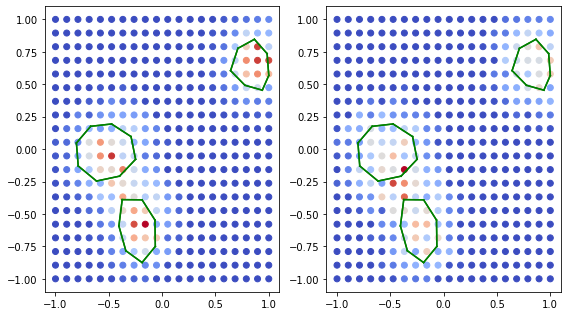

In [49]:
i = 54
chain = chains[i]
c = transposed_chains[i]
m = multis[i]
l = labels[i]


integrals = m @ torch.abs(gen_CDM2(vf, c, d = 5))

integrals.shape

integrals = integrals.detach().numpy()

# make a copy of densities
densities2 = densities.copy()

densities2 = densities2[i].detach().numpy()





fig, ax = plt.subplots(1,2)



ax[0].scatter(trans[:,0], trans[:,1], c = integrals[:,0] * densities2, cmap = 'coolwarm')

ax[1].scatter(trans[:,0], trans[:,1], c = integrals[:,1] * densities2, cmap = 'coolwarm')


plot_chain(chain, ax[0])

plot_chain(chain, ax[1])


# simple_vf_plot(vf, ax[1], radius = radius)

# make plot bigger
fig.set_size_inches(18.5/2, 10.5/2)


# add a colorbar
plt.show()

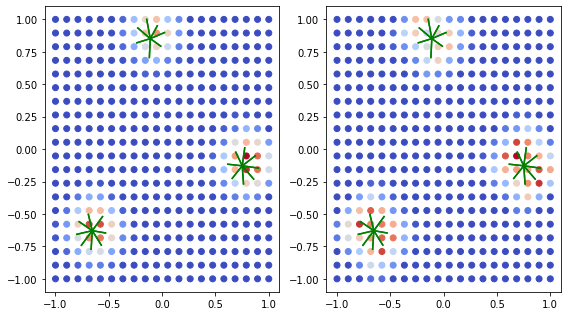

In [47]:
# select a chain
i = 60
chain = chains[i]

# calculate the integrals
c = transposed_chains[i]
m = multis[i]
l = labels[i]
integrals = m @ torch.abs(gen_CDM2(vf, c, d = 5))
integrals = integrals.detach().numpy()

# make a copy of densities
densities2 = densities.copy()
densities2 = densities2[i].detach().numpy()

# plot
fig, ax = plt.subplots(1,2)
ax[0].scatter(trans[:,0], trans[:,1], c = integrals[:,0] * (densities2**2), cmap = 'coolwarm')
ax[1].scatter(trans[:,0], trans[:,1], c = integrals[:,1] * (densities2**2), cmap = 'coolwarm')
plot_chain(chain, ax[0])
plot_chain(chain, ax[1])

# make plot bigger
fig.set_size_inches(18.5/2, 10.5/2)


# add a colorbar
plt.show()

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_25105/839017781.py:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, 2, i+1)


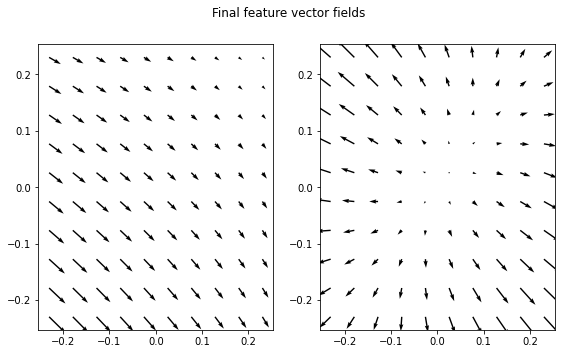

In [48]:
## plot a vector field given a function f: R^2 -> R^2
def plot_component_vf(f, ax, comp = 0, x_range=5, y_range=5):

    x = np.linspace(-x_range,x_range,10)
    y = np.linspace(-y_range,y_range,10)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((10,10))
    V = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor(inp).float()

            tv = f.forward(inp).reshape(2,2)

            U[i,j] = tv[:,comp][0]
            V[i,j] = tv[:,comp][1]
    ax.quiver(X,Y,U,V)

fig, ax = plt.subplots()

# make a figure with 6 subplots arranged in 2 rows and 3 columns
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    plot_component_vf(vf, ax, comp = i, x_range=radius, y_range=radius)


# add a title to the figure
fig.suptitle('Final feature vector fields')

# make plot bigger
fig.set_size_inches(18.5/2, 10.5/2)

plt.show()

# QM9

## Molecules in 3D


In [1]:
import dgl

data = dgl.data.QM9Dataset(label_keys=['mu', 'alpha', 'homo', 'lumo'])

In [96]:
# find max entry in Z for all graphs in data

max = 0
for graph in data:

    if torch.max(graph[0].ndata['Z']) > max:
        max = torch.max(graph[0].ndata['Z'])

print(max)

In [2]:
# plot a nx graph using the edges in graph.edges['uv'] and pos for positions
# a function for turning a path into a chain
def dgl_to_chain(graph):
    """ 
    A function for turning a graph into a chain
    """

    # get node features
    node_features = graph.ndata['R']

    # get edges
    u = graph.edges('uv')[0]
    v = graph.edges('uv')[1]
    edge_index = torch.stack((u,v)).T


    # number of 1-simplices
    r = edge_index.shape[0]

    # embedding dimension
    n = node_features.shape[1]

    # sort the edge indices
    edges = torch.tensor([np.sort([edge_index[i][0],edge_index[i][1]]) for i in range(len(edge_index))])

    # initialize chain
    ch = torch.zeros((r,2,n))

    # turn edges into a 1-chain
    for i in range(r):
        ch[i,0,:] = node_features[edges[i][0]]
        ch[i,1,:] = node_features[edges[i][1]]

    return ch

In [8]:
def plot_chain3d(chain, ax, dgraph= None, c = None):

    for i in range(chain.shape[0]):
        ax.plot(chain[i,:,0],chain[i,:,1], chain[i,:,2], c = 'black')
        # plot nodes
        
    if dgraph != None:
        
        # convert node features to numpy array

        
        for i in range(len(dgraph.ndata['Z'])):
            ax.scatter(dgraph.ndata['R'][i,0],dgraph.ndata['R'][i,1])



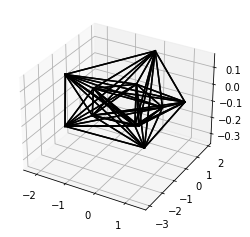

In [9]:
# plot 3d graph
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

graph = data[200][0]

chain = dgl_to_chain(graph)

plot_chain3d(chain,ax)
plt.show()



In [101]:
# use plotly to plot the 3d graph
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=graph.ndata['R'][:,0],
    y=graph.ndata['R'][:,1],
    z=graph.ndata['R'][:,2],
    mode='markers',
    marker=dict(
        size=12,
        color=graph.ndata['Z'],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
)])

# add in the edges to the plot
for i in range(graph.edges('uv')[0].shape[0]):
    fig.add_trace(go.Scatter3d(
        x=[graph.ndata['R'][graph.edges('uv')[0][i]][0],graph.ndata['R'][graph.edges('uv')[1][i]][0]],
        y=[graph.ndata['R'][graph.edges('uv')[0][i]][1],graph.ndata['R'][graph.edges('uv')[1][i]][1]],
        z=[graph.ndata['R'][graph.edges('uv')[0][i]][2],graph.ndata['R'][graph.edges('uv')[1][i]][2]],
        mode='lines',
        line=dict(
            color='black',
            width=2,
        )
    ))




# supress trace information
fig.update_traces(showlegend=False)




# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()


AttributeError: 'tuple' object has no attribute 'ndata'

In [102]:
R = graph.ndata['R']

AttributeError: 'tuple' object has no attribute 'ndata'

In [103]:
Z = graph.ndata['Z']

AttributeError: 'tuple' object has no attribute 'ndata'

In [49]:
# one hot encode Z
Z_oh = torch.nn.functional.one_hot(Z)

Z.shape

torch.Size([11])

In [50]:
Z_oh = Z_oh.float()

In [73]:
# normalize non-zero columns of z_oh
Z_oh = Z_oh / Z_oh.sum(axis = 0)

# replaces nan values with 0
Z_oh = torch.nan_to_num(Z_oh)

Z_oh

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [74]:
R.shape


torch.Size([11, 3])

In [75]:
base = R.T @ Z_oh

In [76]:
base = base[:,[1,6,7]]

In [77]:
Z

tensor([7, 6, 6, 7, 6, 7, 1, 1, 1, 1, 1])

In [78]:
# plot the non-trivial columns of base in 3d using plotly
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=base[0,:],
    y=base[1,:],
    z=base[2,:],
    mode='markers',
    marker=dict(
        size=20,
        color=[1,6,7],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1,
        symbol = 'square'
    )
)])

# tight layou
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()


In [91]:
# use plotly to plot the 3d graph
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=graph.ndata['R'][:,0],
    y=graph.ndata['R'][:,1],
    z=graph.ndata['R'][:,2],
    mode='markers',
    marker=dict(
        size=12,
        color=graph.ndata['Z'],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
)])


fig.add_trace(go.Scatter3d(
    x=base[0,:],
    y=base[1,:],
    z=base[2,:],
    mode='markers',
    marker=dict(
        size=20,
        color=[1,6,7],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1,
        symbol = 'square'
    )
))

fig.add_trace(go.Scatter3d(
    x=[0,base[0,0]],
    y=[0,base[1,0]],
    z=[0,base[2,0]],
    mode='lines',
    line=dict(
        color=[1],
        colorscale='Viridis',
        width=6,
    )
))

fig.add_trace(go.Scatter3d(
    x=[0,base[0,1]],
    y=[0,base[1,1]],
    z=[0,base[2,1]],
    mode='lines',
    line=dict(
        color=[6],
        colorscale='Viridis',
        width=6,
    )
))
fig.add_trace(go.Scatter3d(
    x=[0,base[0,2]],
    y=[0,base[1,2]],
    z=[0,base[2,2]],
    mode='lines',
    line=dict(
        color=[7],
        colorscale='Viridis',
        width=6,
    )
))

# supress trace information
fig.update_traces(showlegend=False)




# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()



In [85]:
# plot vectors from the origin to each column of base
fig = go.Figure(data=[go.Scatter3d(
    x=[0,base[0,0]],
    y=[0,base[1,0]],
    z=[0,base[2,0]],
    mode='lines',
    line=dict(
        color='red',
        width=6,
    )
)])

fig.add_trace(go.Scatter3d(

In [92]:
# calculate the cross product of the first two columns of base
cross = torch.cross(base[:,0],base[:,1])
